# Suffix vs Non-suffix Words

In [44]:
import matplotlib.pyplot as plt


def plot_metrics(train_acc, valid_acc, train_losses, valid_losses):

    plt.style.use('ggplot')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plt.subplots_adjust(hspace=0.5)

    n_epochs = range(1, len(valid_losses) + 1)

    # Plot accuracy
    ax1.set_title('Accuracy Evolution Over Epochs')
    ax1.plot(n_epochs, train_acc, marker='o', color='steelblue', label='Training Accuracy')
    ax1.plot(n_epochs, valid_acc, marker='o', color='orange', label='Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.set_title('Loss Evolution Over Epochs')
    ax2.plot(n_epochs, train_losses, marker='o', color='steelblue', label='Training Loss')
    ax2.plot(n_epochs, valid_losses, marker='o', color='orange', label='Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()


def compare_accuracies(baseline_acc, model_acc):
    
    plt.style.use('ggplot')
    x_labels = ['MFC\nBaseline', 'Model']
    bar_colors = ['lightsteelblue', 'midnightblue']
    bars = plt.bar(x_labels, [baseline_acc, model_acc], width=0.3, color=bar_colors)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

    # plt.title('Comparison of Model Accuracy with Baseline Accuracy (MFC)')
    plt.ylabel('Accuracy')
    plt.show()

### Packages

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

from data_processing import DataGenerator, correct_nasal_vowel_transcripts
from model import GenderLSTM
from model_evaluation import baseline_accuracy, compare_accuracies, statistical_check
from visualization import plot_metrics

### Hyperparameters

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding_dim = 128
hidden_size = 256
batch_size = 64
n_epochs = 20
lr = 0.001

hyperparameters = {
    'embed_dim': embedding_dim,
    'hidden_size': hidden_size,
    'batch_size': batch_size,
    'n_epochs': n_epochs,
    'lr': lr
}

### Datasets

In [3]:
nlexique = pd.read_csv('../data/nlexique.csv')
nlexique = nlexique[['lexeme', 'sg', 'gen']].rename(columns={'sg': 'phon'}).dropna().reset_index(drop=True)
tilde = nlexique.iloc[-1]['phon'][-1]
nlexique['phon'] = nlexique['phon'].apply(correct_nasal_vowel_transcripts)
nlexique

,lexeme,phon,gen
0,à-côté,akOte,m
1,à-coup,aku,m
2,à-peu-près,apØpʁɛ,m
3,à-pic,apik,m
4,à-plat,apla,m
...,...,...,...
30999,zurichois,zyʁikwa,m
31000,zydeco,zidəko,f
31001,zygoma,zigOma,m
31002,zygote,zigɔt,m


In [4]:
# check
nlexique[nlexique['phon'].apply(lambda x: tilde in x)]

,lexeme,phon,gen


In [69]:
echantinom = pd.read_csv('../data/Echantinom-full-20210902.csv')
echantinom = echantinom[~echantinom['lemma'].isin(nlexique[nlexique['gen'] == 'b']['lexeme'])][['lemma', 'gen', 'phon', 'suffix']]
echantinom = pd.merge(echantinom, nlexique, left_on='lemma', right_on='lexeme', how='left', suffixes=('_y', ''))\
           .drop(columns=['lexeme', 'phon_y', 'gen_y']).dropna().reset_index(drop=True)
echantinom

,lemma,suffix,phon,gen
0,berlingue,0,bɛʁl3g,m
1,corton,on,kɔʁt2,m
2,dabuche,uche,dabyʃ,f
3,faf,0,faf,m
4,gail,0,gaj,f
...,...,...,...,...
4527,palu,0,paly,m
4528,talc,0,talk,m
4529,sauvetage,age,sOvətaʒ,m
4530,plaid,0,plɛd,m


## Orthographic forms

In [6]:
# orth_train = nlexique[(~nlexique['lexeme'].isin(echantinom['lemma'])) & (nlexique['gen'] != 'b')][['lexeme', 'gen']]
# orth_train.to_csv('../data/orth_train.csv', index=None)

orth_train = pd.read_csv('../data/orth_train.csv')
orth_train

,lexeme,gen
0,à-côté,m
1,à-coup,m
2,à-peu-près,m
3,à-pic,m
4,à-plat,m
...,...,...
24875,zurichois,m
24876,zydeco,f
24877,zygoma,m
24878,zygote,m


In [64]:
# orth_test = echantinom[['lemma', 'gen']]
# orth_test.to_csv('../data/orth_test.csv', index=None)

orth_test = pd.read_csv('../data/orth_test.csv')
orth_test

,lemma,gen
0,corton,m
1,dabuche,f
7,abatis,m
8,abattant,m
9,ablette,f
...,...,...
1758,pratiquant,m
1759,tournure,f
1760,martinet,m
1761,classeur,m


In [8]:
orth_train_set, orth_valid_set = train_test_split(orth_train, test_size=0.2)

orth_train_generator = DataGenerator(orth_train_set, reverse_nouns=True)
orth_valid_generator = DataGenerator(orth_valid_set, parentgenerator=orth_train_generator, reverse_nouns=True)

orth_model = GenderLSTM(orth_train_generator, embedding_dim, hidden_size, device=DEVICE, reversed=True)
orth_train_metrics, orth_valid_metrics = orth_model.train_model(
    orth_train_generator, orth_valid_generator, n_epochs, batch_size, lr, save_model='../saved_models/nlexique_orth_model.pth'
    )

Epoch: 0
[Train] Loss: 0.3734   Accuracy: 84.99%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 63.17%
[Valid] Loss: 0.3830   Accuracy: 82.24%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 68.35%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.2554   Accuracy: 89.79%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 67.53%
[Valid] Loss: 0.3842   Accuracy: 84.14%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 66.05%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.2353   Accuracy: 90.78%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 63.46%
[Valid] Loss: 0.2559   Accuracy: 89.26%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 64.92%
---------------------------------------------

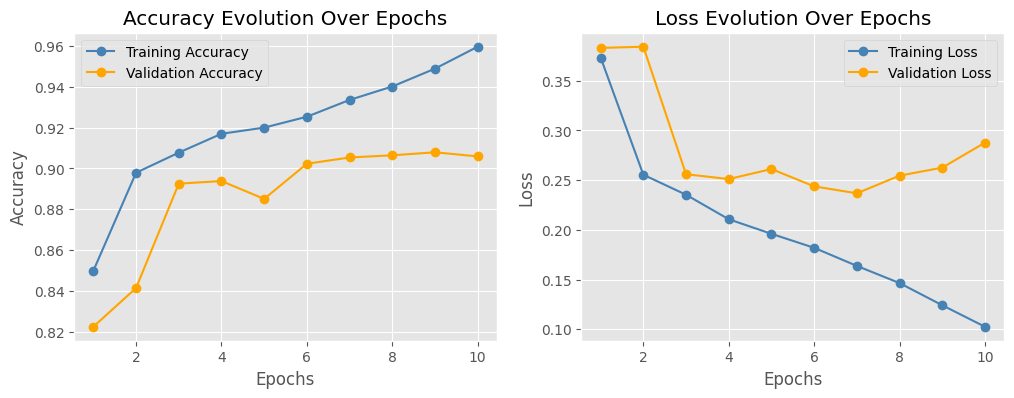

In [20]:
plot_metrics(orth_train_metrics['accuracy'], orth_valid_metrics['accuracy'], orth_train_metrics['loss'], orth_valid_metrics['loss'])

The most frequent label in the dataset is: m


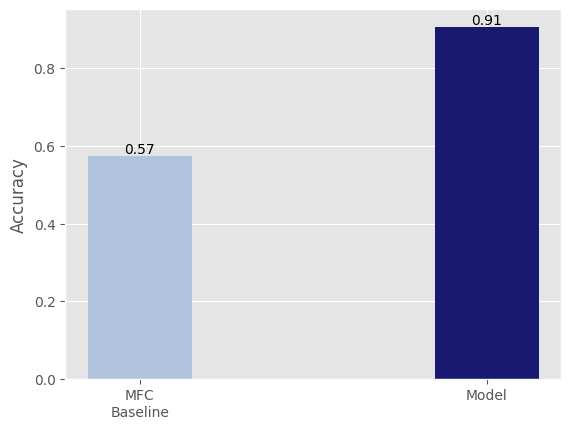

In [45]:
baseline_acc = baseline_accuracy(orth_train_generator, orth_valid_generator, verbose=True)

compare_accuracies(baseline_acc, orth_valid_metrics['accuracy'][-1])

In [38]:
orth_test_generator = DataGenerator(orth_test, parentgenerator=orth_train_generator, reverse_nouns=True)
orth_predictions = orth_model.predict(orth_test_generator, batch_size, set='test')

orth_predictions_df = pd.merge(pd.DataFrame(orth_predictions), echantinom[['lemma', 'phon']], left_on='Form', right_on='lemma', how='left').drop('lemma', axis=1)
orth_predictions_df.insert(1, 'Alt Form', orth_predictions_df.pop('phon'))
orth_predictions_df.to_csv('../results/echantinom_orth_preds_new.csv', index=False)

In [49]:
statistical_check(orth_train_set, orth_valid_set, orth_test, hyperparameters, outfile='../results/echantinom_orth_preds_x10_new.csv', runs=10, reverse_nouns=True, device=DEVICE)

'Results successfully written to ../results/echantinom_orth_preds_x10_new.csv'

## Phonetic forms

In [39]:
# phon_train = nlexique[(~nlexique['lexeme'].isin(echantinom['lemma'])) & (nlexique['gen'] != 'b')][['phon', 'gen']]
# phon_train.to_csv('../data/phon_train.csv', index=None)

phon_train = pd.read_csv('../data/phon_train.csv')
phon_train

,phon,gen
0,akOte,m
1,aku,m
2,apØpʁɛ,m
3,apik,m
4,apla,m
...,...,...
24875,zyʁikwa,m
24876,zidəko,f
24877,zigOma,m
24878,zigɔt,m


In [67]:
# phon_test = echantinom[['phon', 'gen']]
# phon_test.to_csv('../data/phon_test.csv', index=None)

phon_test = pd.read_csv('../data/phon_test.csv')
phon_test

,phon,gen
0,bɛʁl3g,m
1,kɔʁt2,m
2,dabyʃ,f
3,faf,m
4,gaj,f
...,...,...
4527,paly,m
4528,talk,m
4529,sOvətaʒ,m
4530,plɛd,m


In [41]:
phon_train_set, phon_valid_set = train_test_split(phon_train, test_size=0.2)

phon_train_generator = DataGenerator(phon_train_set, reverse_nouns=True)
phon_valid_generator = DataGenerator(phon_valid_set, parentgenerator=phon_train_generator, reverse_nouns=True)

phon_model = GenderLSTM(phon_train_generator, embedding_dim, hidden_size, device=DEVICE, reversed=True)
phon_train_metrics, phon_valid_metrics = phon_model.train_model(
    phon_train_generator, phon_valid_generator, n_epochs, batch_size, lr, save_model='../saved_models/nlexique_phon_model.pth'
    )

Epoch: 0
[Train] Loss: 0.4224   Accuracy: 79.14%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.05%
[Valid] Loss: 0.5258   Accuracy: 70.56%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.35%
----------------------------------------------------------------------------------------------------
Epoch: 1
[Train] Loss: 0.3598   Accuracy: 82.73%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.73%
[Valid] Loss: 0.3933   Accuracy: 81.09%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.07%
----------------------------------------------------------------------------------------------------
Epoch: 2
[Train] Loss: 0.3264   Accuracy: 84.69%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 58.08%
[Valid] Loss: 0.3705   Accuracy: 82.13%   Beginning of plateau (index): 0   Accuracy at the beginning of plateau: 56.81%
---------------------------------------------

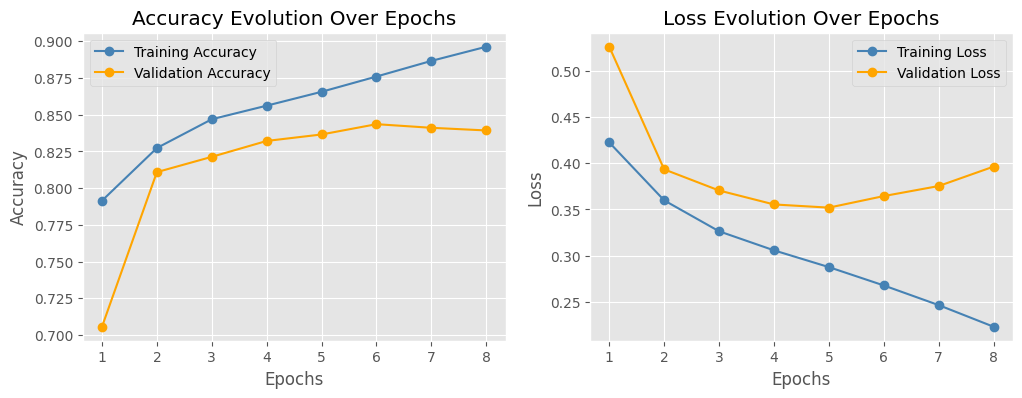

In [42]:
plot_metrics(phon_train_metrics['accuracy'], phon_valid_metrics['accuracy'], phon_train_metrics['loss'], phon_valid_metrics['loss'])

The most frequent label in the dataset is: m


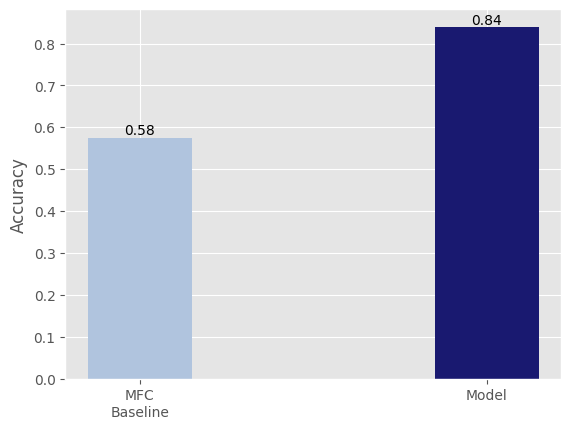

In [46]:
baseline_acc = baseline_accuracy(phon_train_generator, phon_valid_generator, verbose=True)

compare_accuracies(baseline_acc, phon_valid_metrics['accuracy'][-1])

In [47]:
phon_test_generator = DataGenerator(phon_test, parentgenerator=phon_train_generator, reverse_nouns=True)
phon_predictions = phon_model.predict(phon_test_generator, batch_size, set='test')

phon_predictions_df = pd.merge(pd.DataFrame(phon_predictions), echantinom[['lemma', 'phon']], left_on='Form', right_on='phon', how='left').drop('phon', axis=1)
phon_predictions_df.insert(1, 'Alt Form', phon_predictions_df.pop('lemma'))
phon_predictions_df.to_csv('../results/echantinom_phon_preds_new.csv', index=False)

In [48]:
statistical_check(phon_train_set, phon_valid_set, phon_test, hyperparameters, outfile='../results/echantinom_phon_preds_x10_new.csv', runs=10, reverse_nouns=True, device=DEVICE)

'Results successfully written to ../results/echantinom_phon_preds_x10_new.csv'